In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## **RETRAINING - NEW DATA WITH FLORIDA**

In [4]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/justinkirk8/Accidentally_Late/main/accidents_sample_joined.csv')
df.head()

,severity,state_code,region,division,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,year,date,classification
0,short_delay,CA,West,Pacific,76.0,10.0,9.0,0.0,clear_weather,Day,2019,2019-06-27,PreCOVID
1,short_delay,OR,West,Pacific,67.0,10.0,0.0,0.0,clear_weather,Day,2019,2019-06-05,PreCOVID
2,long_delay,VA,South,South Atlantic,52.0,10.0,8.0,0.0,clear_weather,Day,2019,2019-04-01,PreCOVID
3,short_delay,CA,West,Pacific,66.0,10.0,6.0,0.0,clear_weather,Night,2019,2019-10-06,PreCOVID
4,short_delay,CA,West,Pacific,59.0,10.0,0.0,0.0,clear_weather,Night,2020,2020-02-06,PreCOVID


In [5]:
# Check dtypes, features should be float64
df.dtypes

severity              object
state_code            object
region                object
division              object
temperature_f        float64
visibility_mi        float64
wind_speed_mph       float64
precipitation_in     float64
weather_condition     object
sunrise_sunset        object
year                   int64
date                  object
classification        object
dtype: object

In [6]:
# Get the number of rows
df.shape[0]

500000

In [7]:
# Get count of unique values in the 'Severity' column
print(df['severity'].value_counts())

short_delay    446404
long_delay      53596
Name: severity, dtype: int64


In [8]:
# Get count of unique values in the 'state_code', 'region', 'division'
print(df['state_code'].value_counts())
print(df['region'].value_counts())
print(df['division'].value_counts())

CA    175500
FL     52755
OR     40126
MN     24114
TX     18629
NY     16277
VA     14482
UT     14440
PA     12501
SC     11533
NC     11286
NJ      9392
IL      7949
MI      7783
TN      7225
MD      7061
AZ      6866
GA      6617
LA      6446
CO      6158
WA      5942
CT      4645
MO      3653
AL      2943
IN      2723
OH      2378
MT      1983
AR      1831
IA      1355
WI      1280
ID      1267
DC      1252
WV      1164
KS      1152
OK       997
MA       993
NH       986
KY       959
MS       884
RI       845
NE       725
ME       689
DE       688
NV       619
NM       360
ND       235
VT       142
WY       126
SD        44
Name: state_code, dtype: int64
West         253387
South        146752
Midwest       53391
Northeast     46470
Name: region, dtype: int64
Pacific               221568
South Atlantic        106838
Middle Atlantic        38170
Mountain               31819
West North Central     31278
West South Central     27903
East North Central     22113
East South Central    

In [9]:
# Drop REGION, year, date and division columns
df.drop('region', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)
df.drop('division', axis=1, inplace=True)
df.head()

,severity,state_code,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
0,short_delay,CA,76.0,10.0,9.0,0.0,clear_weather,Day,PreCOVID
1,short_delay,OR,67.0,10.0,0.0,0.0,clear_weather,Day,PreCOVID
2,long_delay,VA,52.0,10.0,8.0,0.0,clear_weather,Day,PreCOVID
3,short_delay,CA,66.0,10.0,6.0,0.0,clear_weather,Night,PreCOVID
4,short_delay,CA,59.0,10.0,0.0,0.0,clear_weather,Night,PreCOVID


In [10]:
# Filter dataframe for just "FL" data
df = df.loc[df['state_code']== 'FL']
df.head()

,severity,state_code,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
5,short_delay,FL,81.0,9.0,12.7,0.0,bad_weather,Day,PreCOVID
64,long_delay,FL,78.0,7.0,6.0,0.0,clear_weather,Day,PreCOVID
67,long_delay,FL,84.0,10.0,6.0,0.0,clear_weather,Day,PreCOVID
136,long_delay,FL,71.0,10.0,13.0,0.0,clear_weather,Day,PreCOVID
154,long_delay,FL,82.0,10.0,15.0,0.0,clear_weather,Night,PreCOVID


In [11]:
# Drop "state_code" - Florida results
df.drop('state_code', axis=1, inplace=True)
df.head()


,severity,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
5,short_delay,81.0,9.0,12.7,0.0,bad_weather,Day,PreCOVID
64,long_delay,78.0,7.0,6.0,0.0,clear_weather,Day,PreCOVID
67,long_delay,84.0,10.0,6.0,0.0,clear_weather,Day,PreCOVID
136,long_delay,71.0,10.0,13.0,0.0,clear_weather,Day,PreCOVID
154,long_delay,82.0,10.0,15.0,0.0,clear_weather,Night,PreCOVID


In [12]:
# Get count of unique values in the 'Weather_Condition' column
print(df['weather_condition'].value_counts())
print(df['sunrise_sunset'].value_counts())
print(df['classification'].value_counts())

clear_weather    46511
bad_weather       6244
Name: weather_condition, dtype: int64
Day      36233
Night    16522
Name: sunrise_sunset, dtype: int64
COVID       44226
PreCOVID     8529
Name: classification, dtype: int64


In [13]:
# Transform "sunrise_sunset", "weather_condition", and "classification" to binary feature
df.sunrise_sunset = df.sunrise_sunset.replace({'Day': 1, 'Night': 0}) 
df.weather_condition = df.weather_condition.replace({'clear_weather': 1, 'bad_weather': 0})
df.classification = df.classification.replace({'PreCOVID': 1, 'COVID': 0})
df.head()

,severity,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
5,short_delay,81.0,9.0,12.7,0.0,0,1,1
64,long_delay,78.0,7.0,6.0,0.0,1,1,1
67,long_delay,84.0,10.0,6.0,0.0,1,1,1
136,long_delay,71.0,10.0,13.0,0.0,1,1,1
154,long_delay,82.0,10.0,15.0,0.0,1,0,1


In [14]:
# Get count of unique values in the 'Weather_Condition' column
print(df['weather_condition'].value_counts())
print(df['sunrise_sunset'].value_counts())

1    46511
0     6244
Name: weather_condition, dtype: int64
1    36233
0    16522
Name: sunrise_sunset, dtype: int64


In [15]:
#df = pd.get_dummies(df, columns=['region'])
#df.head()

In [16]:
# Calculate Correlations
df.corr()

,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
temperature_f,1.000000,0.142118,0.220748,-0.019692,0.012516,0.452603,0.074340
visibility_mi,0.142118,1.000000,0.019110,-0.382285,0.568621,0.020924,-0.027373
wind_speed_mph,0.220748,0.019110,1.000000,0.028382,-0.039874,0.277779,0.011201
precipitation_in,-0.019692,-0.382285,0.028382,1.000000,-0.343292,0.036519,0.042237
weather_condition,0.012516,0.568621,-0.039874,-0.343292,1.000000,-0.062315,-0.060014
sunrise_sunset,0.452603,0.020924,0.277779,0.036519,-0.062315,1.000000,0.052527
classification,0.074340,-0.027373,0.011201,0.042237,-0.060014,0.052527,1.000000


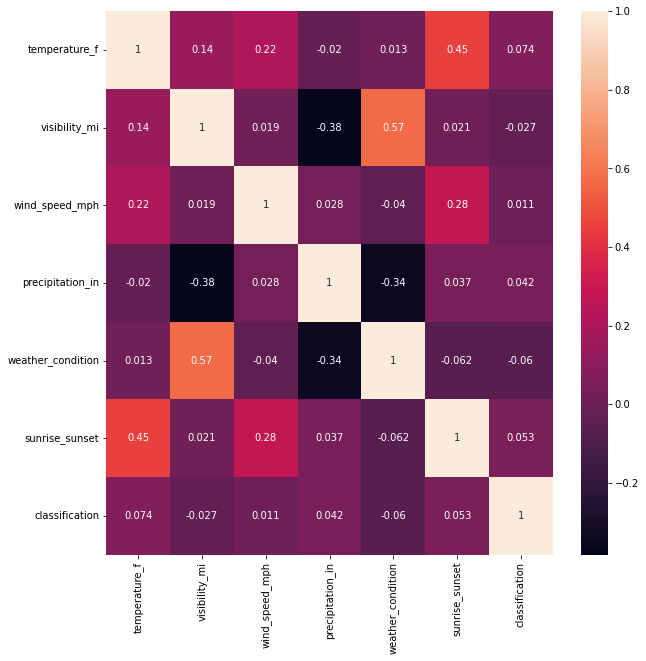

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot corr - lighter color closest to 1 perfect correlation; darkest is negative correlation - FLORIDA
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

## **SPLIT THE DATA INTO TRAINING AND TESTING**

In [18]:
# Create our target

y = df["severity"].ravel()
X = df.drop(columns="severity")
y[:5]

array(['short_delay', 'long_delay', 'long_delay', 'long_delay',
       'long_delay'], dtype=object)

In [19]:
X.describe()

,temperature_f,visibility_mi,wind_speed_mph,precipitation_in,weather_condition,sunrise_sunset,classification
count,52755.000000,52755.000000,52755.000000,52755.000000,52755.000000,52755.000000,52755.000000
mean,76.121789,9.540393,8.217996,0.009111,0.881642,0.686816,0.161672
std,9.782743,1.658864,4.997418,0.062075,0.323035,0.463793,0.368153
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,10.000000,5.000000,0.000000,1.000000,0.000000,0.000000
50%,78.000000,10.000000,8.000000,0.000000,1.000000,1.000000,0.000000
75%,83.000000,10.000000,12.000000,0.000000,1.000000,1.000000,0.000000
max,102.000000,10.000000,161.000000,2.030000,1.000000,1.000000,1.000000


In [20]:
from sklearn.model_selection import train_test_split
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
Counter(y_train)



Counter({'short_delay': 36018, 'long_delay': 3548})

### **Random Forest Classifier**

In [21]:
from sklearn.preprocessing import StandardScaler
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 


In [23]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [24]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.9210705891273031


In [26]:
# Display the confusion matrix - RandomFC
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual long_delay", "Actual short_delay"], columns=["Predicted long_delay", "Predicted short_delay"])
cm_df

,Predicted long_delay,Predicted short_delay
Actual long_delay,540,612
Actual short_delay,429,11608


In [27]:
# Print the classification report
print("Classification Report")
print(classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

  long_delay       0.56      0.47      0.51      1152
 short_delay       0.95      0.96      0.96     12037

    accuracy                           0.92     13189
   macro avg       0.75      0.72      0.73     13189
weighted avg       0.92      0.92      0.92     13189



### **Ranked Features by Importance**

In [28]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.19320376, 0.03465704, 0.14524258, 0.03916592, 0.00713111,
       0.02011292, 0.56048666])

In [29]:
# We can sort the features by their importance. Can try improving model by dropping lower ranked features. 
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5604866579026069, 'classification'),
 (0.19320376481703386, 'temperature_f'),
 (0.1452425800181923, 'wind_speed_mph'),
 (0.03916591874587397, 'precipitation_in'),
 (0.03465704107663922, 'visibility_mi'),
 (0.020112922456667594, 'sunrise_sunset'),
 (0.007131114982986273, 'weather_condition')]

In [30]:
# Creat dataframe of features ranked
export = pd.DataFrame(importances)
export.head()

,0
0,0.193204
1,0.034657
2,0.145243
3,0.039166
4,0.007131


In [31]:
# Creating CSV file for features ranked 
export.to_csv('FL_Features_ranked.csv')